In [1]:
# Marcin Damek, M.Cem Eriş, Mehmet Sezer, Recep O. Yıldız
# {damek20, erismu, sezer20, yildizr} @itu.edu.tr

# ITU BLG 549E Graph Theory and Algorithms Project

# Reference Metadata: 
# https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz

# Project Directory: 
# https://github.com/mumtazcem/GraphProject

# *****************************************************************************
# IMPORTANT NOTE:

# The Amazon Product Co-Purchasing Network Metadata Dataset in [1] has
# 548552 Products, 7781990 Reviews and 15010575 lines of data which is
# in total 977.5 MB.

# Due to its huge size, it takes nearly 40 minutes of parsing in a regular
# laptop. Therefore we decided to put parser code in a different Jupyter
# Notebook File named: amazon_metadata_parser.ipynb

# In order to save time to run this Jupyter Notebook file, the parsed data
# is stored in csv format. If there is a need to run the code from scratch
# please follow the steps below

# 1. Download the metadata [1] and save it in the same directory with the
#    Jupyter Notebook File named: amazon_metadata_parser.ipynb.
# 2. It creates all the matrices to run the analyzer and also images required
#    for the markdown cells of this file.
# 3. If the other products are desired for analysis, the product types 
#    should be changed.
# 4. After the successful execution of the amazon_metadata_parser.ipynb,
#    this Jupyter Notebook file is ready to be run.
# *****************************************************************************

import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import random
import pprint

# 1. Graph Datasets
### (1) Present your graphs G1 and G2 (number of nodes, edges, what a node and edge denote).
#### Selected Graphs
SNAP (Stanford Network Analysis Project) Amazon Product Co-Purchasing Network Metadata Dataset is used in this project. This metadata can be accessed via reference [2]. <br>

In this project it is aimed to discover the most popular products in videos and DVDs seperately. To do that the most crowded modules namely core modules are examined in great depth and the results are compared to the random graphs which are correlated with the original graphs. As a matter of fact, we would like to enhance the recommendation system of Amazon and other similar e-commerce websites. Therefore, we decided to analyze the modularity and centrality of the items in order to shed light to their relations.

Due to big size of products given below in numbers, Videos and DVDs are utilized. We have chosen "Videos" for Graph G1 and "DVDs" for Graph G2.

|Graphs      |Nodes |Edges|
|:-----------|:----:|----:|
|G1 (Videos) |26131 |16211|
|G2 (DVDs)   |19828 |39575|

The node degree distributions of both graphs are given below.

* The Node Degree Distribution of Graph G1
![degree_dist_G1](image_files/degree_dist_G1.png)

* The Node Degree Distribution of Graph G2
![degree_dist_G2](image_files/degree_dist_G2.png)

Since the number of nodes and edges are relatively high, it is decided to <b>remove the nodes with less than a designated node degree</b>. Therefore, the optimized graphs have the following features.

|Graphs      |Nodes |Edges|Threshold Node Degree|
|:-----------|:----:|:---:|:-------------------:|
|G1 (Videos) |453   |632  |13                   |
|G2 (DVDs)   |658   |818  |16                   |

#### Node and Edge Representation
Each product in the metadata <b>creates a node</b> in the graphs. For the clear understanding of the edge representation, the metadata representation and its fields are given below.


|Field       |Explanation |
|:-----------|:-----------|
|Id          |Product Identification Number|
|ASIN        |Amazon Standard Identification Number [3]|
|Title       |Name/Title of The Product|
|Group       |Product Group (Book, DVD, Video or Music)|
|Salesrank   |Amazon Salesrank|
|Similar     |ASINs of Co-purchased Products (People who buy X also buy Y)|
|Categories  |Location in Product Category Hierarchy to Which the Product Belongs (Separated By Pipe Character, Category ID in [])|
|Reviews     |Product Review Information: Time, User ID, Rating, Total Number of Votes on the Review, Total Number of Helpfulness Votes (Note)|

* Note: How many people found the review to be helpful?

One of the products in the metadata is given as an example:

<b>Id</b>: 123499<br>
<b>ASIN</b>: 6304812663<br>
<b>title</b>: Spice Girls - Girl Power (Live in Istanbul)<br>
<b>group</b>: Video<br>
<b>salesrank</b>: 19875<br>
<b>similar</b>: 5  6305212139  6304683235  0767808673  B00000JQV6  6305112401<br>
<b>categories</b>: 7<br>

    |[139452]|VHS[404272]|Genres[404274]|Music Video & Concerts[133]|Other Music[511482]|British[169252]
    ...
<b>reviews</b>: total: 44  downloaded: 44  avg rating: 4.5<br>

    1998-3-25  customer:  ATVPDKIKX0DER  rating: 5  votes:   0  helpful:   0
    1998-4-11  customer:  ATVPDKIKX0DER  rating: 5  votes:   0  helpful:   0
    1998-4-23  customer:  ATVPDKIKX0DER  rating: 5  votes:   0  helpful:   0
    ...

For edge representation "similar" field is used as an edge between two products. If there is a video which has a similar ASIN number which refers to an other type of product, it is ignored. The weight of an edge is assigned to a positive number by <b><u>summing up the total votes given to both of the products</u></b>. An example for the edge weight calculation is given below.
 
![Edge General Image](image_files/image_edges_general.png)

### (2) Display the adjacency matrices of both graphs. 

* Video Graph (G1) Adjacency Matrix
![AdjMatrixG1Raw](image_files/AdjMatrixG1Raw.png)

* DVDs Graph (G2) Adjacency Matrix
![AdjMatrixG2Raw](image_files/AdjMatrixG2Raw.png)

#### Colorbar is utilised in order to increase the perception of the adjacency matrices.

* Video Graph (G1) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG1VMax1](image_files/AdjMatrixG1VMax1.png)

* DVDs Graph (G2) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG2VMax1](image_files/AdjMatrixG2VMax1.png)

* Zoomed Video Graph (G1) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG1VMax1Zoomed](image_files/AdjMatrixG1VMax1Zoomed.png)

* Zoomed DVDs Graph (G2) Adjacency Matrix with Enhanced Colorbar
![AdjMatrixG2VMax1Zoomed](image_files/AdjMatrixG2VMax1Zoomed.png)

### (3) Plot the node degree distributions of both graphs in an overlaid manner.

* The Node Degree Distributions of both Graph G1 and G2
![g1_g2_distr_overlaid](image_files/g1_g2_distr_overlaid.png)

# 2. Graph Theory Principle

### (1) Present the mathematical principle or concept to explore.

Two concepts are utilised in this project. Therefore it is aimed to explore whether the nodes with high PageRank Centralities are the member of the crowded modules.

#### PageRank Centrality

PageRank centrality is derived from eigenvector centrality in which the in-degree of a node is examined as well as the number of connection of a node and its neighbors [4]. PageRank Centrality is utilised in order to find the central products in the given graphs.

#### Girvan-Newman Algorithm for Finding the Modules and the Core of the Graph
In order to calculate the modules in the graphs the Girvan-Newman Algorithm is utilised. With Girvan-Newman Algorithm, the graphs are decomposed into the modules with the highest modularity.

### (2) Include a figure illustrating how it works on small graphs.

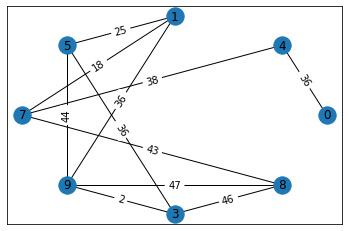

PageRank Centrality Values for Each Node
{0: 0.07434604971614908,
 1: 0.10431731434884489,
 3: 0.10726107753511382,
 4: 0.1267907852474603,
 5: 0.1302964297195128,
 7: 0.13780144436119215,
 8: 0.16485555192567644,
 9: 0.15433134714605046}

Girvan-Newman Algorithm is applied to Random Graph

The best modularity value of Random Graph : 0.39857817143523105
Number of connected components (modules): 5 

Module Number and its Elements:
Module 1 : 0 4 
Module 2 : 1 
Module 3 : 5 
Module 4 : 7 
Module 5 : 8 9 3 

End of GirvanNewmanAlgorithm


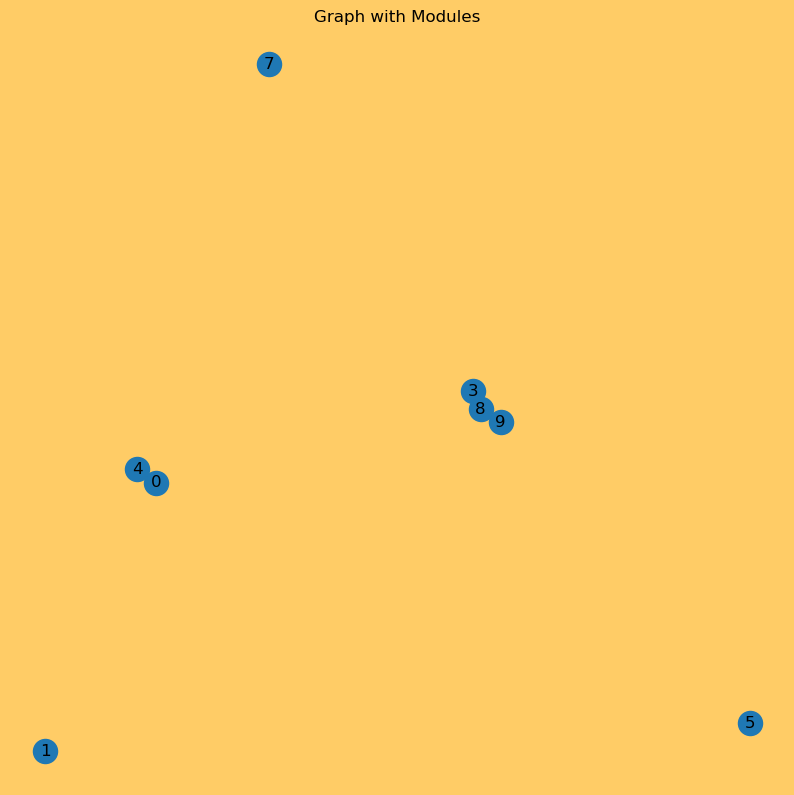

In [2]:
def RandomAdjacencyMatrix(n, p):
    M = np.zeros((n,n), dtype=np.uint8)
    for i in range(n):
        for j in range(i+1, n):
            if np.random.rand() < p:
                M[i,j], M[j, i] = 1, 1
    return M

def RandomGraph(n, p, startw, stopw):
    '''
    Creates a random networkx undirected, unweighted graph
    
    Inputs:
        n: number of nodes in graph
        p: probability of an edge being included
        startw: start value for weight
        stopw: stop value of weight
        
    Outputs:
        M: Adjacency matrix as numpy array
        G: nx Graph
        
    '''
    M = RandomAdjacencyMatrix(n, p)
    edges = np.transpose(np.where(M==1))
    
    G = nx.Graph()
    for i in range(edges.shape[0]):
        G.add_edge(edges[i, 0], edges[i, 1], weight = random.randrange(startw, stopw))
    
    return G, M

def VisualizeGraph(G):
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()

def pagerank_centrality(G, alphaVal, max_iteration):
    return nx.pagerank(G, alpha = alphaVal, weight = "weight", max_iter = max_iteration)
    
'''
Girvan-Newman Algortihm Steps:
1. Calculate the betweenness centrality of each edge in graph G
2. Remove the edge with the highest betweenness centrality. Choose randomly in case same score occurs.
3. Recalculate the betweenness centrality of all remaining edges
4. Repeat steps 2 and 3 until no edges remain.
'''

# For step 1 we need to find the edge with highest betweenness centrality 
def EdgeWithHighBetweennessC(G):
    '''
    Parameters
    ----------
    G : A NetworkX graph.

    Returns
    -------
    node_x, node_y : Node_x-Node_y edge with highest betweenness centrality.
    '''

    if (G.number_of_edges == 0):
        return 0, 0
    
    else:
        edgetuple = nx.edge_betweenness_centrality(G).items()    

        # We need to find the highest value, therefore we should sort the tuples
        sortedEdgeTuple = sorted(edgetuple, key = lambda x:x[1], reverse = True)

        return sortedEdgeTuple[0][0][0], sortedEdgeTuple[0][0][1]

# For step 2 we need to remove the edge with highest betweenness centrality
def RemoveEdgeWHBWC(G):
    '''
    Notes
    -----
    RemoveEdgeWHBWC
    Remove the edge with highest betweenness centrality
    
    Parameters
    ----------
    G : A NetworkX graph.

    Returns
    -------
    G : A NetworkX graph with an edge with highest betweenness centrality is removed.
    '''
    x, y = EdgeWithHighBetweennessC(G)
    
    # Remove the edge with highest betweenness centrality
    G.remove_edge(x, y)
    # print("Remove Edge:", x, y, "# Edges:", G.number_of_edges())
    
    return G
    
def ModularityValue(G):
    '''
    Parameters
    ----------
    G : A NetworkX graph.

    Returns
    -------
    modularity_value : Modularity value of the given graph.
    '''
    if (G.number_of_edges() == 0):
        return 0
    
    else:
        modularity_value = nx_comm.modularity(G, nx_comm.label_propagation_communities(G))
        return modularity_value

def NumberOfConnectedComponents(G):
    '''
    Parameters
    ----------
    G : A NetworkX graph.

    Returns
    -------
    nu_connected_components : Number of connected components of the given graph.
    '''
    nu_connected_components = nx.number_connected_components(G)
    return nu_connected_components

def GirvanNewmanAlgorithm(G, gName):
    print("\nGirvan-Newman Algorithm is applied to", gName)
    
    # Create a graph with the best modularity components
    bestGraph = nx.empty_graph()
    
    # Calculate and keep the modularity value
    modularity = ModularityValue(G)
    modularity_best = modularity
    components_best = list(nx.connected_components(G))
    
    # Run the algorithm till the last edge exists
    while (nx.number_of_edges(G) > 0):
        
        # Run the loop till get a new component
        given_nu_Connected_Components = NumberOfConnectedComponents(G)
        while (given_nu_Connected_Components == NumberOfConnectedComponents(G)):
            RemoveEdgeWHBWC(G)
        
        # Since we get new a component, we can calculate the modularity
        # and compare it with the best modularity found so far
        modularity_current = ModularityValue(G)
        
        # Determine the best modularity
        if (modularity_current > modularity_best):
            modularity_best = modularity_current
            components_best = list(nx.connected_components(G))
            bestGraph = nx.Graph(G)
        
    if (modularity_best == modularity):
        print("\nWe cannot apply Girvan-Newman Algorithm to graph", gName, "It only has one module.")
        print("Modularity Value is:", modularity_best)
    else:
        print("\nThe best modularity value of", gName, ":", modularity_best)
        print("Number of connected components (modules):", len(components_best), "\n")
        print("Module Number and its Elements:")
        
        i = 0
        for row in components_best:
            i = i + 1
            print("Module", i, ":", end = ' ')
            for val in row:
                print(val, end = ' ')
            print()
            
    print("\nEnd of GirvanNewmanAlgorithm")
    return bestGraph

def DrawGraph(G, NetworkData, size):
    '''
    Draws the given networkx graph, with given name and size
    
    Parameters:
        G: Networkx Graph
        NetworkData : Name of the graph printed on the drawing.
        size: Image size of the graph
        
    Returns:
        None.
    '''
    plt.figure(num=None, figsize=(size, size), dpi=100, facecolor='#FFCC66')
    plt.axis('off')
    plt.title(NetworkData)

    # Define layout for the graph drawing
    pos = nx.spring_layout(G)
    nx.draw_networkx(G)
    plt.show()  

def ShowPageRank(G, alphaVal, max_iteration):
    results = pagerank_centrality(G, alphaVal, max_iteration)
    print("PageRank Centrality Values for Each Node")
    pprint.pprint(results)

# n : Number of nodes    
n = 10
p = 0.2
strtw = 1
stopw = 50

max_iteration = 1000
alphaVal = 0.8 
image_size = 10

G, M = RandomGraph(n, p, strtw, stopw)
VisualizeGraph(G)

ShowPageRank(G, alphaVal, max_iteration)

Gtemp = G.copy()
Gtemp = GirvanNewmanAlgorithm(Gtemp, "Random Graph")
DrawGraph(Gtemp, "Graph with Modules", image_size)

### (3) Formalize the principle mathematically and present your mathematical symbols and equations with comments and explanations.

#### PageRank Algorithm

* Node: u
* PageRank Value of Node u: PR(u)
* Nodes Connected to Node u: B(u)
* Number of Outgoing Edges on Node u: N(u)
* Damping Factor [0 to 1]: d

\begin{equation*}
PR(u) = \sum_{v \in B(u)}^{} \frac{PR(v)}{N(v)}
\end{equation*}

We can also formulate;

\begin{equation*}
PR(u) = (1 - d) + d x \sum_{v \in B(u)}^{} \frac{PR(v)}{N(v)}
\end{equation*}

#### Modularity

* Modularity: M
* Normalization: 1/2L where L equals to number of edges in the graph
* Adjacency Matrix: A((i)(j))
* Degree of a Node i: k(i) 
* probability a random edge would go between i and j: k(i)k(j)/2L
* If node i is in module 1, then s(i) = 1

\begin{equation*}
M = \frac{1}{2L} \sum_{i,j=1}^{N} (A_{ij} - \frac{k_ik_j}{2L}) \delta c_i,c_j
\end{equation*}

#### Girvan-Newman Algorithm
* Calculate the betweenness centrality of each edge in graph G.
* Remove the edge with the highest betweenness centrality. Choose randomly in case same score occurs.
* Recalculate the betweenness centrality of all remaining edges.
* Repeat steps 2 and 3 until no edges remain.

#### Morphospace Operations
The Morphospace includes a x axis which holds the module degree and y axis holds the average of PageRank Centrality values of all nodes in that module.

\begin{equation*}
Module Degree = Max (All Modules of G)
\end{equation*}

\begin{equation*}
Average PR(u) = \frac{\sum_{v \in Module}^{} PR(v)}{|v|}
\end{equation*}

# 3. The R Space

### (1) Define R between two graph-driven metrics or properties P1 and P2 to better investigate the graph theory principle/concept you selected in Section II. Justify your rationale for exploring such relationship.

It is aimed to discover and investigate whether the most crowded modules' (<b>P1 Property</b>) member nodes are central in terms of centrality mesaures (<b>P2 Property</b>).

The Girvan-Newman Algorithm is used in order to detect modules in graphs and the PageRank Algorithm is utilized as a centrality measure.

Due to high computation time for running those algorithms on graphs, it is decided to compute the average of Pagerank values in the most crowded module utilised by Girvan-Newman.

The computation times are provided below with a i7 processsor.

|Process                               |Time         |
|:-------------------------------------|:-----------:|
|Full Parsing of Amazon Metadata       |40 mins      |
|Computation for Morphospace           |95 mins      |
|Computation for Modularity (3K Nodes)*|2 hours      |

This is why (*) the graphs are heavily thresholded. To the point, the project's focus is on nearly %1 of the graphs by applying node degree threshold.

### (2, 3) Simulate n1 = 100 random graphs derived from G1 with same node strength distribution. Simulate n2 = 100 random graphs derived from G2 with same node strength distribution. Detail the simulation strategy.

Maslov-Sneppen Algorithm is utilized in order to create 100 graphs for each G1 and G2. Then as a next step the randomization is executed. After choosing two edges randomly, those edges are replaced with other nodes in such a way that their in-degree, out-degree stay unchanged. In steps, the A-B and C-D edges are randomly selected and then their edges are changed to edge(A-D) and edge(C-B). The weights of the edges are copied too. If such a connection is already existed (edge(A-D), edge(C-B) or both) the swap is interrupted and it is searched for another random pair.

* Strength Distributions of G1 (left) and Random Graphs (right)
![StrDistributionG1vsRandomG1TwoPlots](image_files/StrDistributionG1vsRandomG1TwoPlots.png)

* Strength Distributions of G2 (left) and Random Graphs (right)
![StrDistributionG2vsRandomG2TwoPlots](image_files/StrDistributionG2vsRandomG2TwoPlots.png)

### (4) For each anchor graph Gi, plot its node strength distribution overlaid with that of the simulated graphs from Gi. 

G1 Graph Node Strength Distribution with Simulated Graphs from G1
![StrDistributionG1vsRandomG1](image_files/StrDistributionG1vsRandomG1.png)

G2 Graph Node Strength Distribution with Simulated Graphs from G2

![StrDistributionG2vsRandomG2](image_files/StrDistributionG2vsRandomG2.png)

### (5) Plot the anchor graphs in the R space (as star) and the simulated graph populations in dots. For a better visualization, use two different colors.

* The Morphospace for Modularity vs Centrality 
![Morphospace_Random_30_Plots](image_files/Morphospace_Random_30_Plots.png)

# 4. Result Interpretation and Discussion
### Discuss and interpret the simulated graph behavior in the R space. Compare both simulated datasets and anchor graphs and derive conclusions.

In the morphospace, specifically on the x-axis, there should be a better metric to represent the graphs instead of module degree. The core module of the graphs should be extracted from the graph and a clear metric for this calculation should be proposed for the future work. In fact, the "coreness" value of the module would support analyzers to enhance their recommendation systems.

In Ref [6], it is asserted that the real networks generally consist of tightly connected nodes which are connected to the other nodes of the network in a modular way. Yet, not much study has been carried out on modularity using this kind of e-commerce metadata. It has been also shown that the dynamics of the network are affected by the modular structure of the graphs. Therefore we tried to extract these core modules and see how they are related to the similar and famous products.

For future work, it is essential to use the whole graph nodes and edge relations to see the real connections and the real popular products. Because whenever a threshold is applied, a lot of crucial information, namely edges are lost. In addition to that, we assert that the products that are in highly populated modules would yield essential similarity between them in terms of how many upvotes that their comments get. Using these modules, Amazon’s Customers Who Bought This Also Bought feature can be optimized.

According to our analysis we are the first group to analyze the Amazon metadata with Modularity and Pagerank centrality. To conclude we tried to analyze the modularity and centrality of the items in order to shed light to their relations.

## References

[1] “Amazon Product Metadata and Reviews from Summer 2006.” [Online]. Available: https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz. [Accessed: 31-Jan-2021].<br>
[2] “Amazon Product Co-purchasing Network Metadata.” [Online]. Available: https://snap.stanford.edu/data/amazon-meta.html. [Accessed: 31-Jan-2021].<br>
[3] “What are UPCs, EANs, ISBNs. and ASINs?” [Online]. Available: https://www.amazon.com/gp/seller/asin-upc-isbn-info.html. [Accessed: 31-Jan-2021].<br>
[4] Page, Lawrence and Brin, Sergey and Motwani, Rajeev and Winograd, Terry (1999) The PageRank Citation Ranking: Bringing Order to the Web. Technical Report. Stanford InfoLab.<br>
[5] Girvan M. and Newman M. E. J., Community structure in social and biological networks, Proc. Natl. Acad. Sci. USA 99, 7821–7826 (2002).<br>
[6] Ghalmane, Z., El Hassouni, M., Cherifi, C. et al. Centrality in modular networks. EPJ Data Sci. 8, 15 (2019). https://doi.org/10.1140/epjds/s13688-019-0195-7

In [3]:
## Pre-Compiled Morphospace Calculations

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import project_view as pv
import networkx.algorithms.community as nx_comm
import random
import time

# Seed value for betweenness centrality and for random choices
seed = 900

# Most Crowded Modules would be saved to..
g1_modules_file = "most_crowded_modules/g1_modules.csv"
g2_modules_file = "most_crowded_modules/g2_modules.csv"

# Page Ranks would be saved to..
g1_pagerank_file = "page_ranks/g1_pagerank_file.csv"
g2_pagerank_file = "page_ranks/g2_pagerank_file.csv"

# Database
g1_pd = "saved_dataframes/g1Db_clean.csv"
g2_pd = "saved_dataframes/g2Db_clean.csv"
g1_db = pd.read_csv(g1_pd)
g2_db = pd.read_csv(g2_pd)

# Fix nodeId column
num_of_nodes1, col1 = g1_db.shape
g1_db['nodeId'] = np.full((num_of_nodes1,), range(num_of_nodes1))
num_of_nodes2, col2 = g2_db.shape
g2_db['nodeId'] = np.full((num_of_nodes2,), range(num_of_nodes2))

# Generate networkx version of our graphs here
def generate_g1_g2():
    # Thresholded
    adj1_file = "saved_adj_matrices/adj1_min.csv"
    adj2_file = "saved_adj_matrices/adj2_min.csv"

    adj_1_pd = pd.read_csv(adj1_file)
    adj_2_pd = pd.read_csv(adj2_file)

    # need to drop index column that is generated by pandas
    adj_1_pd.drop(adj_1_pd.columns[0], axis=1, inplace=True)
    adj_2_pd.drop(adj_2_pd.columns[0], axis=1, inplace=True)

    # convert pd to numpy
    adj_1 = adj_1_pd.to_numpy()
    adj_2 = adj_2_pd.to_numpy()

    # generate nx graphs from adj matrices
    G1 = nx.from_numpy_matrix(adj_1)
    G2 = nx.from_numpy_matrix(adj_2)

    num_of_nodes, num_of_edges = pv.get_nodes_and_edges_number(G1)
    print("Number of nodes :", num_of_nodes, "number of edges :", num_of_edges)
    # pv.plot_degree_dist(G1)

    num_of_nodes, num_of_edges = pv.get_nodes_and_edges_number(G2)
    print("Number of nodes :", num_of_nodes, "number of edges :", num_of_edges)
    # pv.plot_degree_dist(G2)
    return G1, G2


# Modified Girvan-Newman algorithm from HW3
def modified_girvan_newman_algorithm(g):
    initial = nx_comm.modularity(g, [set(g.nodes)], weight='weight')
    max_modularity = initial
    saved_components = []
    saved_graph = nx.Graph()
    while g.number_of_edges() != 0:
        centralities = nx.edge_betweenness_centrality(g, weight='weight', seed=seed)
        # max() returns one of the edges with maximum centrality
        u, v = max(centralities, key=centralities.get)
        # Checking for same maximum centrality score below
        if len(sorted(centralities.values(), reverse=True)) > 2:
            centrality_max1 = sorted(centralities.values(), reverse=True)[0]
            centrality_max2 = sorted(centralities.values(), reverse=True)[1]
            if centrality_max1 == centrality_max2:
                # At least two equal max centrality measure detected!
                same_scores = []
                for centrality in centralities:
                    if centralities[centrality] == centrality_max1:
                        same_scores.append(centrality)
                # Pick an edge randomly among same scores
                u, v = random.Random(seed).choice(same_scores)
        # same score check finishes.
        components = sorted(nx.connected_components(g), key=len, reverse=True)
        if len(components) > 1:
            fragmented_modularity = nx_comm.modularity(g, components, weight='weight')
            if fragmented_modularity > max_modularity:
                max_modularity = fragmented_modularity
                saved_components = components
                saved_graph = g.copy()
        g.remove_edge(u, v)
    return max_modularity, saved_components, saved_graph


def most_crowded_module(all_components):
    max_len = 0
    most_crowded_modules = []
    for component in all_components:
        if max_len < len(component):
            max_len = len(component)
    for component in all_components:
        if max_len == len(component):
            most_crowded_modules.append(component)
    return max_len, most_crowded_modules


# Gets two graphs, runs Girvan Newman algorithm
# Finds connected components. Among connected components,
# it would print out the most crowded connected components
# to csv files under most_crowded_modules folder.
def modularity_calculations(G1, G2, filename1, filename2):
    start_time = time.time()
    print("******   Modularity Calculation Started   ******")
    print("Running G1")
    result_modularity, g1_result_components, result_graph = modified_girvan_newman_algorithm(G1)
    print("Final modularity: ", result_modularity)
    print("Connected components of the graph with maximum modularity: ", g1_result_components)
    g1_max_len, g1_most_crowded_modules = most_crowded_module(g1_result_components)
    print("most_crowded_module include : ", g1_max_len, " nodes.")
    print("most_crowded_modules: ", g1_most_crowded_modules)

    g1_time = time.time()
    print("G1 modularity is finished in --- %s seconds ---" % (g1_time - start_time))

    print("Running G2")
    result_modularity, g2_result_components, result_graph = modified_girvan_newman_algorithm(G2)
    print("Final modularity: ", result_modularity)
    print("Connected components of the graph with maximum modularity: ", g2_result_components)
    g2_max_len, g2_most_crowded_modules = most_crowded_module(g2_result_components)
    print("most_crowded_module include : ", g2_max_len, " nodes.")
    print("most_crowded_modules: ", g2_most_crowded_modules)

    g2_time = time.time()
    print("G2 is finished --- %s seconds ---" % (g2_time - g1_time))
    print("Modularity finished in %s seconds." % (time.time() - start_time))
    print("******   Modularity Calculation Ended   ******")

    print("Printing modules of G1..")
    g1_modules_asin = []
    for module_ in g1_result_components:
        module_asin = []
        for product in module_:
            module = g1_db[g1_db['nodeId'] == product]
            module_asin.append(module['ASIN'].iat[0])
        g1_modules_asin.append(module_asin)
    df1 = pd.DataFrame(g1_modules_asin)

    # the number of nodes in the corresponding module
    df1['NumberOfNodes'] = ""
    for row_index, row in df1.iterrows():
        node_counter = 0
        for column in row:
            if column is not None:
                node_counter += 1
        df1.at[row_index, 'NumberOfNodes'] = node_counter - 1
    with open(filename1, 'w', newline='') as myfile:
        df1.to_csv(filename1)

    print("Printing modules of G2..")
    g2_modules_asin = []
    for module_ in g2_result_components:
        module_asin = []
        for product in module_:
            module = g2_db[g2_db['nodeId'] == product]
            module_asin.append(module['ASIN'].iat[0])
        g2_modules_asin.append(module_asin)
    df2 = pd.DataFrame(g2_modules_asin)
    # the number of nodes in the corresponding module
    df2['NumberOfNodes'] = ""
    for row_index, row in df2.iterrows():
        node_counter = 0
        for column in row:
            if column is not None:
                node_counter += 1
        df2.at[row_index, 'NumberOfNodes'] = node_counter - 1  # minus 1 because of NumberOfNodes column
    with open(filename2, 'w', newline='') as myfile:
        df2.to_csv(filename2)
    return df1, df2


def page_rank_calculations(G1, G2):
    # G1
    pr = nx.pagerank(G1, alpha=0.9, max_iter=1000, weight='weight')
    sorted_pr = {k: v for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)}
    # print(sorted_pr)
    g1_pr_df = pd.DataFrame.from_dict(sorted_pr, orient='index')
    g1_pr_df["ASIN"] = ""
    for index, row in g1_pr_df.iterrows():
        product = g1_db[g1_db['nodeId'] == index]
        g1_pr_df.at[index, 'ASIN'] = product['ASIN'].iat[0]

    # G2
    pr = nx.pagerank(G2, alpha=0.9, max_iter=1000, weight='weight')
    sorted_pr = {k: v for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)}
    # print(sorted_pr)
    g2_pr_df = pd.DataFrame.from_dict(sorted_pr, orient='index')
    g2_pr_df["ASIN"] = ""
    for index, row in g2_pr_df.iterrows():
        product = g2_db[g2_db['nodeId'] == index]
        g2_pr_df.at[index, 'ASIN'] = product['ASIN'].iat[0]
    return g1_pr_df, g2_pr_df


# Searches over modules, finds the corresponding module for the input ASIN
def search_modules(modules_dataframe, input_asin):
    for index, row in modules_dataframe.iterrows():
        for column_asin in row:
            if column_asin == input_asin:
                return index, modules_dataframe.at[index, 'NumberOfNodes']


# Given pagerank and modularity, this method would create the R space that includes
# node's
# ID
# PageRank
# ASIN
# Module degree
# Module that it belongs to
def create_relationship_space(graph_pagerank, graph_modularity):
    # Add module degree column. Module degree represents the number of nodes in the module that this node belongs to
    graph_pagerank["ModuleDegree"] = ""
    # Given pagerank find its corresponding module ID that this node belongs to
    graph_pagerank["BelongsTo"] = ""
    for index, row in graph_pagerank.iterrows():
        product_asin = graph_pagerank.at[index, 'ASIN']
        # search over modules
        module_index, module_degree = search_modules(graph_modularity, product_asin)
        graph_pagerank.at[index, 'BelongsTo'] = module_index
        graph_pagerank.at[index, 'ModuleDegree'] = module_degree

    return graph_pagerank


# Calculate pagerank sum of the most popular module and return the module degree of the graph
def morphospace_values(graph_pagerank, graph_modularity, is_reading_from_file):
    sum_pagerank = 0
    for i in range(len(graph_modularity.columns) - 2):
        if is_reading_from_file:
            product_asin = graph_modularity.at[0, str(i)]
        else:
            product_asin = graph_modularity.at[0, i]
        # For file reading, use this below
        # product_asin = graph_modularity.at[0, str(i)]
        # graph_modularity.loc[graph_modularity.index[0], 6]
        # get its pagerank
        for index, row in graph_pagerank.iterrows():
            if product_asin == row['ASIN']:
                # 0 is the column name unfortunately for the pagerank
                if is_reading_from_file:
                    sum_pagerank += row['0']
                else:
                    sum_pagerank += row[0]
                break
    return sum_pagerank, graph_modularity.at[0, 'NumberOfNodes']


def do_calculations_using_file(file1_pr, file2_pr, file1_mod, file2_mod):
    g1_pagerank = pd.read_csv(file1_pr)
    g2_pagerank = pd.read_csv(file2_pr)
    g1_modularity = pd.read_csv(file1_mod)
    g2_modularity = pd.read_csv(file2_mod)

    # Get morphospace values for graphs
    sum_page_rank1, mod_degree1 = morphospace_values(g1_pagerank, g1_modularity, is_reading_from_file=True)
    sum_page_rank2, mod_degree2 = morphospace_values(g2_pagerank, g2_modularity, is_reading_from_file=True)
    print(sum_page_rank1/mod_degree1)
    print(mod_degree1)
    print(sum_page_rank2/mod_degree2)
    print(mod_degree2)
    return sum_page_rank1, mod_degree1, sum_page_rank2, mod_degree2


# Provide file names to be written to
def do_all_calculations(G1, G2, file_mod1, file_mod2, file_pr1, file_pr2):
    # Calculate pagerank and modules
    g1_pagerank, g2_pagerank = page_rank_calculations(G1, G2)
    g1_modularity, g2_modularity = modularity_calculations(G1, G2, file_mod1, file_mod2)

    # Create the R space
    g1_relationship = create_relationship_space(g1_pagerank, g1_modularity)
    g2_relationship = create_relationship_space(g2_pagerank, g2_modularity)
    # Get morphospace values for graphs
    sum_page_rank1, mod_degree1 = morphospace_values(g1_pagerank, g1_modularity, is_reading_from_file=False)
    sum_page_rank2, mod_degree2 = morphospace_values(g2_pagerank, g2_modularity, is_reading_from_file=False)
    print(sum_page_rank1)
    print(mod_degree1)
    print(sum_page_rank2)
    print(mod_degree2)
    # Write to a file
    with open(file_pr1, 'w', newline='') as myfile:
        g1_relationship.to_csv(g1_pagerank_file)
    with open(file_pr2, 'w', newline='') as myfile:
        g2_relationship.to_csv(g2_pagerank_file)
    return sum_page_rank1, mod_degree1, sum_page_rank2, mod_degree2

# Generate real G1 G2
G1, G2 = generate_g1_g2()
do_all_calculations(G1, G2, g1_modules_file, g2_modules_file, g1_pagerank_file, g2_pagerank_file)
# do_calculations_using_file(g1_pagerank_file, g2_pagerank_file, g1_modules_file, g2_modules_file)



Number of nodes : 453 number of edges : 632
Number of nodes : 658 number of edges : 818
******   Modularity Calculation Started   ******
Running G1
Final modularity:  0.9794256865499167
Connected components of the graph with maximum modularity:  [{32, 33, 35, 147, 29, 31}, {322, 8, 73, 426, 311}, {160, 154, 273, 308, 58}, {291, 104, 215, 61, 350}, {128, 129, 430, 305, 155}, {293, 390, 134, 136, 397}, {103, 109, 389, 7}, {336, 40, 11, 111}, {17, 314, 315, 151}, {26, 263, 285, 165}, {41, 124, 126, 95}, {49, 386, 177, 446}, {232, 82, 164, 332}, {197, 182, 213, 94}, {137, 420, 433, 108}, {224, 298, 387, 117}, {265, 186, 132, 239}, {233, 428, 141, 157}, {447, 374, 158, 230}, {161, 393, 429, 206}, {417, 194, 203, 166}, {361, 171, 437, 227}, {178, 226, 180, 207}, {0, 280, 432}, {1, 2, 138}, {409, 6, 135}, {218, 10, 253}, {229, 14, 183}, {21, 422, 22}, {24, 185, 170}, {140, 42, 356}, {50, 51, 127}, {56, 290, 152}, {57, 385, 139}, {64, 330, 174}, {66, 284, 175}, {419, 68, 391}, {353, 74, 438}, 

(0.014420723493317023, 6, 0.011236631337383094, 7)

In [ ]:
import random
import pandas as pd
import networkx as nx
from main import do_all_calculations, do_calculations_using_file
import matplotlib.pyplot as plt
import numpy as np

# Seed value for betweenness centrality and for random choices
random.seed(900)


# Generates randomized graphs while keeping the node strength distribution
def randomize_graphs(G, number_of_new_graphs):
    new_graphs = []
    for graph_number in range(number_of_new_graphs):
        tmp_graph = G.copy()
        nodes_number = tmp_graph.number_of_nodes()
        for i in range(nodes_number):
            # container for selected randomly, two existing, different edges
            selectedEdges = []
            while len(selectedEdges) < 2:
                firstPartEdge = random.randrange(0, nodes_number - 1)
                secondPartEdge = random.randrange(0, nodes_number - 1)
                # checking if edge exist and if is not in selectdEdges
                if tmp_graph.has_edge(firstPartEdge, secondPartEdge) and (
                        firstPartEdge, secondPartEdge) not in selectedEdges and (
                        secondPartEdge, firstPartEdge) not in selectedEdges:
                    selectedEdges.append((firstPartEdge, secondPartEdge))
            # check if new connection exist. If exist, skip and go to random new pair
            if tmp_graph.has_edge(selectedEdges[0][0], selectedEdges[1][1]) or tmp_graph.has_edge(selectedEdges[1][0],
                                                                                                  selectedEdges[0][1]):
                selectedEdges.clear()
                continue
            edge_0_weight = tmp_graph.get_edge_data(*selectedEdges[0])['weight']
            edge_1_weight = tmp_graph.get_edge_data(*selectedEdges[1])['weight']
            # remove edge for swap start and end point in edge
            tmp_graph.remove_edge(*selectedEdges[0])
            tmp_graph.remove_edge(*selectedEdges[1])
            # add new changed edges
            tmp_graph.add_edge(selectedEdges[0][0], selectedEdges[1][1], weight=edge_0_weight)
            tmp_graph.add_edge(selectedEdges[1][0], selectedEdges[0][1], weight=edge_1_weight)
            selectedEdges.clear()
        new_graphs.append(tmp_graph)
    return new_graphs


# Thresholded
adj1_file = "saved_adj_matrices/adj1_min.csv"
adj2_file = "saved_adj_matrices/adj2_min.csv"

adj_1_pd = pd.read_csv(adj1_file)
adj_2_pd = pd.read_csv(adj2_file)

# need to drop index column that is generated by pandas
adj_1_pd.drop(adj_1_pd.columns[0], axis=1, inplace=True)
adj_2_pd.drop(adj_2_pd.columns[0], axis=1, inplace=True)

# convert pd to numpy
adj_1 = adj_1_pd.to_numpy()
adj_2 = adj_2_pd.to_numpy()

# generate nx graphs from adj matrices
G1 = nx.from_numpy_matrix(adj_1)
G2 = nx.from_numpy_matrix(adj_2)

# this value is our n1 and n2, modify however you like
# but be aware it would take a lot of time
# the computation time is explained in jupyter notebook.
number_of_random_graphs = 1
g1_random_graphs = randomize_graphs(G1, number_of_random_graphs)
g2_random_graphs = randomize_graphs(G2, number_of_random_graphs)

print("Random graphs are created.")

mod_degrees_x_g1 = []
mod_degrees_x_g2 = []
page_ranks_y_g1 = []
page_ranks_y_g2 = []
# Real G1
# 0.0026914075090193903
# 6
# Real G2
# 0.002812468086869622
# 7
# Include G1 and G2
mod_degrees_x_g1.append(6)
mod_degrees_x_g2.append(7)
page_ranks_y_g1.append(0.0026914075090193903)
page_ranks_y_g2.append(0.002812468086869622)
for g1, g2 in zip(g1_random_graphs, g2_random_graphs):
    sum_page_rank1, mod_degree1, sum_page_rank2, mod_degree2 = do_all_calculations(g1, g2,
                                                                                   file_mod1="random_graph_results/g1rand_modules2.csv",
                                                                                   file_mod2="random_graph_results/g2rand_modules.csv",
                                                                                   file_pr1="random_graph_results/g1rand_pr2.csv",
                                                                                   file_pr2="random_graph_results/g2rand_pr2.csv")

    mod_degrees_x_g1.append(mod_degree1)
    page_ranks_y_g1.append(sum_page_rank1 / mod_degree1)
    mod_degrees_x_g2.append(mod_degree2)
    page_ranks_y_g2.append(sum_page_rank2 / mod_degree2)

data1 = {'ModuleDegrees': mod_degrees_x_g1,
         'PageRank': page_ranks_y_g1}
# Create DataFrame
df1 = pd.DataFrame(data1)

data2 = {'ModuleDegrees': mod_degrees_x_g2,
         'PageRank': page_ranks_y_g2}
# Create DataFrame
df2 = pd.DataFrame(data2)


Random graphs are created.
******   Modularity Calculation Started   ******
Running G1
Final modularity:  0.9836899540015385
Connected components of the graph with maximum modularity:  [{8, 16, 13}, {132, 12, 39}, {102, 14, 271}, {82, 372, 61}, {104, 292, 94}, {107, 452, 348}, {337, 401, 131}, {136, 390, 134}, {440, 214, 143}, {297, 430, 305}, {0, 125}, {1, 403}, {201, 2}, {115, 3}, {4, 213}, {6, 295}, {182, 7}, {9, 137}, {280, 10}, {50, 11}, {310, 15}, {17, 172}, {19, 109}, {400, 20}, {21, 22}, {120, 23}, {24, 358}, {26, 298}, {394, 28}, {448, 29}, {150, 30}, {299, 31}, {32, 244}, {33, 196}, {49, 34}, {35, 166}, {36, 207}, {184, 37}, {40, 127}, {41, 447}, {56, 42}, {43, 251}, {44, 383}, {240, 45}, {51, 388}, {52, 431}, {387, 53}, {171, 54}, {81, 55}, {57, 385}, {58, 148}, {323, 59}, {211, 60}, {378, 62}, {321, 63}, {64, 331}, {65, 398}, {67, 243}, {218, 68}, {74, 69}, {397, 70}, {277, 71}, {72, 303}, {75, 231}, {338, 76}, {77, 79}, {368, 83}, {84, 269}, {123, 85}, {209, 86}, {347, 87}

In [ ]:
df1.head(2)

In [ ]:
df2.head(2)